In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench import save_results, load_results
from ema_workbench import (Model, RealParameter, perform_experiments, ScalarOutcome)

from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [3]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [4]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [5]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

In [169]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)

reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "discount rate 0": 3.5,
    "discount rate 1": 3.5,
    "discount rate 2": 3.5,
    "ID flood wave shape": 4,
}
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})
    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

nfe = 115000
new_levers = levers
convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimizer_sven_2.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

espilon = [1e3] * len(dike_model.outcomes)
espilon2 = [1018360, 919840, 4191000, 100180, 0.1]

In [170]:
espilon2

[1018360, 919840, 4191000, 100180, 0.1]

In [171]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_optimization, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="levers",
        epsilons=espilon2,
        convergence=convergence_metrics,
        reference=ref_scenario,
        # constraints=constraints
    )

[MainProcess/INFO] pool started with 16 workers

100%|███████████████████████████████▊| 114480/115000 [1:20:21<00:22, 23.59it/s]
115290it [1:20:44, 23.80it/s]                                                  
[MainProcess/INFO] optimization completed, found 228 solutions
[MainProcess/INFO] terminating pool


In [172]:
results = results_optimization, convergence
save_results(results, 'data/runs/optimization_sven_2.tar.gz')

KeyError: 'epsilon_progress'

KeyError: "filename 'experiments metadata.csv' not found"

In [12]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

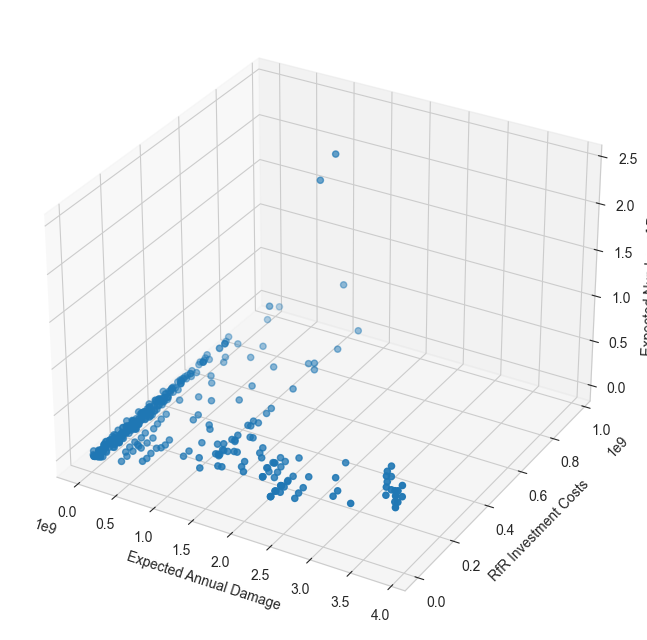

In [304]:
from mpl_toolkits.mplot3d import Axes3D  

outcomes = results_optimization.loc[:, ['Expected Annual Damage', 'RfR Investment Costs', 'Expected Number of Deaths']]

fig = plt.figure(figsize=(8,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outcomes['Expected Annual Damage'], outcomes['RfR Investment Costs'], outcomes['Expected Number of Deaths'])
ax.set_xlabel('Expected Annual Damage')
ax.set_ylabel('RfR Investment Costs')
ax.set_zlabel('Expected Number of Deaths')
plt.show()

In [307]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('max_P') 
plt.show()

AttributeError: 'dict' object has no attribute 'apply'

In [175]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem

def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel(r"$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

In [176]:
archives = ArchiveLogger.load_archives(f"./archives/optimizer_sven.tar.gz")

reference_set = results_optimization
problem = to_problem(dike_model, searchover="levers")

hv = HypervolumeMetric(reference_set, problem)

hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel(r'$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

In [177]:
archives = ArchiveLogger.load_archives(f"./archives/optimizer_sven.tar.gz")
reference_set = archives[max(archives.keys())] # this is the final archive
reference_set = reference_set.drop(columns=['Unnamed: 0'])
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

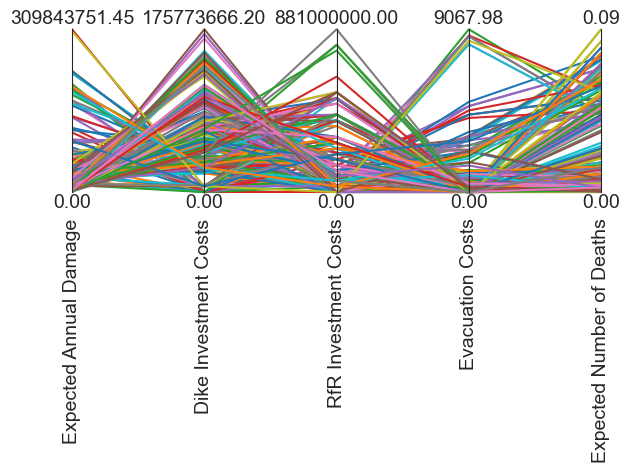

In [178]:
data = results_optimization.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'RfR Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
# paraxes.invert_axis('max_P')
plt.show()

In [179]:
results_optimization

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,8.512385e+07,0.000000e+00,236500000.0,2584.757757,0.050355
1,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,5.085230e+07,0.000000e+00,267200000.0,0.000000,0.066837
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.968212e+08,3.269490e+07,0.0,9067.983901,0.047249
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.098438e+08,0.000000e+00,0.0,8720.808847,0.057200
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1.421926e+08,0.000000e+00,115300000.0,4789.872367,0.069671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,0,1,0,0,0,0,1,1,0,1,...,0,0,3,0,0,4.067823e+06,1.026698e+08,267200000.0,281.619724,0.000515
224,0,1,0,0,0,0,0,0,0,0,...,0,0,3,0,0,2.057469e+07,1.058941e+08,84600000.0,1479.453246,0.002426
225,0,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,3.847042e+06,4.281842e+07,540300000.0,269.695948,0.000351
226,1,0,0,0,0,0,0,1,0,0,...,0,0,3,0,0,3.755268e+06,1.152402e+08,115300000.0,0.000000,0.002640


In [188]:
import numpy as np

condition_deaths = results_optimization['Expected Number of Deaths'] < 0.3
condition_damage = results_optimization['Expected Annual Damage'] <  1.227898e+05
condition_RfRcosts = results_optimization['RfR Investment Costs'] > 176700000.0
condition_dikecosts = results_optimization['Dike Investment Costs'] < 3.043865e+08

logical = condition_deaths  & condition_damage & condition_RfRcosts &condition_dikecosts 

np.sum(logical)

2

In [186]:
l = 8.827852e+07 + 881000000.0
l

969278520.0

In [184]:
policies = results_optimization[logical]
# policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)
# policies['total costs'] = policies['RfR Investment Costs'] + policies['Dike Investment Costs']
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
170,1,0,1,0,0,0,1,1,1,1,...,0,0,2,0,0,0.0,7.885005e+07,503700000.0,0.0,0.0
208,0,1,0,0,0,0,1,1,1,1,...,0,0,1,0,0,0.0,7.630904e+07,540300000.0,0.0,0.0


In [209]:

from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
policies_to_evaluate

[Policy({'0_RfR 0': 1.0, '0_RfR 1': 0.0, '0_RfR 2': 1.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 1.0, '3_RfR 0': 1.0, '3_RfR 1': 0.0, '3_RfR 2': 1.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 0.0, 'A.1_DikeIncrease 0': 0.0, 'A.1_DikeIncrease 1': 0.0, 'A.1_DikeIncrease 2': 0.0, 'A.2_DikeIncrease 0': 2.0, 'A.2_DikeIncrease 1': 0.0, 'A.2_DikeIncrease 2': 0.0, 'A.3_DikeIncrease 0': 0.0, 'A.3_DikeIncrease 1': 0.0, 'A.3_DikeIncrease 2': 0.0, 'A.4_DikeIncrease 0': 3.0, 'A.4_DikeIncrease 1': 0.0, 'A.4_DikeIncrease 2': 0.0, 'A.5_DikeIncrease 0': 2.0, 'A.5_DikeIncrease 1': 0.0, 'A.5_DikeIncrease 2': 0.0, 'Expected Annual Damage': 0.0, 'Dike Investment Costs': 78850053.33576109, 'RfR Investment Costs': 503700000.0, 'Evacuation Costs': 0.0, 'Expected Number of Deaths': 0.0}),
 Policy({'0_RfR 0': 0.0, '0_RfR 1': 1.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 

In [190]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_8policies = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 1000 scenarios * 2 policies * 1 model(s) = 2000 experiments

100%|██████████████████████████████████████| 2000/2000 [01:22<00:00, 24.22it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [92]:
save_results(results_8policies, 'data/runs/results_sven_policies_2.tar.gz')
# results2 = load_results('data/runs/open_exploration_1000sc_1pol.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\svenk\Documents\GitHub\EPA141A-Model-based-decision-making\final assignment\data\runs\results_sven_policies.tar.gz


In [191]:
outcomes['Expected Number of Deaths']

0      0.050355
1      0.066837
2      0.047249
3      0.057200
4      0.069671
         ...   
223    0.000515
224    0.002426
225    0.000351
226    0.002640
227    0.013959
Name: Expected Number of Deaths, Length: 228, dtype: float64

In [192]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [193]:
experiments, outcomes = results_8policies

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
170,1.085852e+17,0.000000,0.0,0.000000e+00,0.097453
208,2.884679e+17,1.137093,0.0,1.108546e+08,0.002384


In [194]:
all = experiments
print(outcome)
for key, outcome_df in outcomes.items():
    print(key, outcome_df)
    # all = pd.concat([all, outcome_df], axis=1)
# all

ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function=<function sum_over at 0x0000028D30A17240>)
Expected Annual Damage [4.58043149e+07 5.93686420e+07 5.30101844e+07 ... 7.00970379e+06
 1.21451906e+06 1.82538186e+09]
Dike Investment Costs [78850053.33576109 78850053.33576109 78850053.33576109 ...
 76309037.45427957 76309037.45427957 76309037.45427957]
RfR Investment Costs [5.037e+08 5.037e+08 5.037e+08 ... 5.403e+08 5.403e+08 5.403e+08]
Evacuation Costs [    0.             0.             0.         ...   537.39737984
    89.82718559 25623.01637704]
Expected Number of Deaths [7.55827396e-02 9.77363907e-02 2.45784539e-02 ... 1.72069534e-03
 1.23413925e-04 1.55538956e-01]


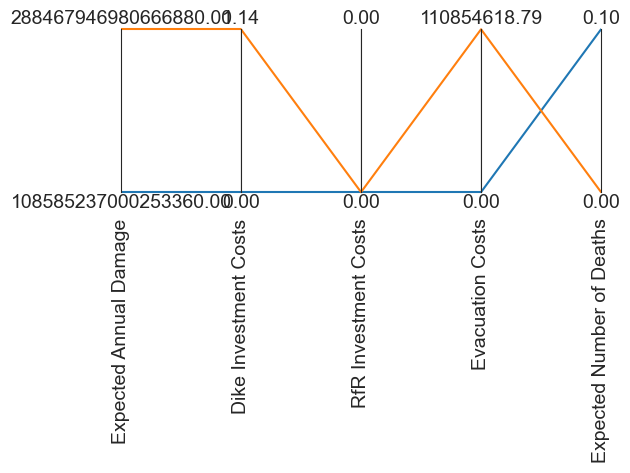

In [195]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
# limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
# paraxes.invert_axis('max_P')
plt.show()

In [196]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [197]:
experiments, outcomes = results_8policies

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

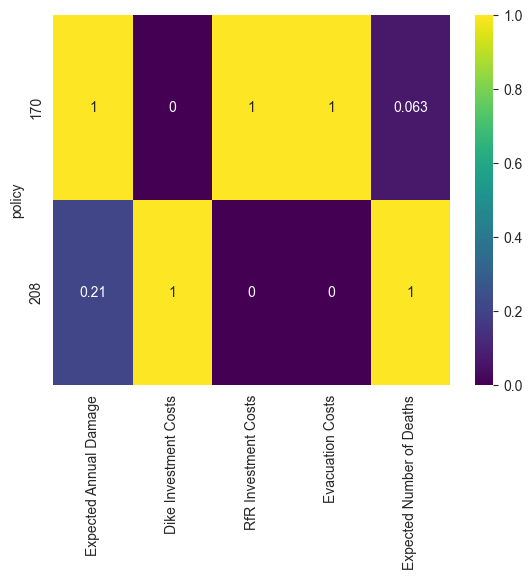

In [198]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

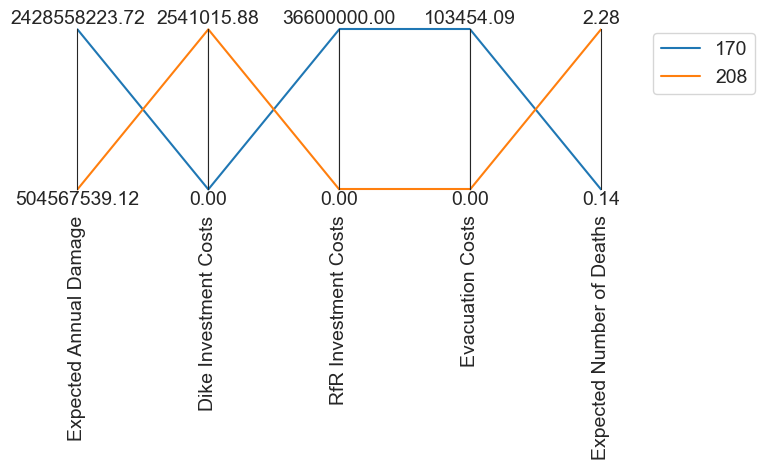

In [199]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
# limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [103]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\5699562.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\5699562.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


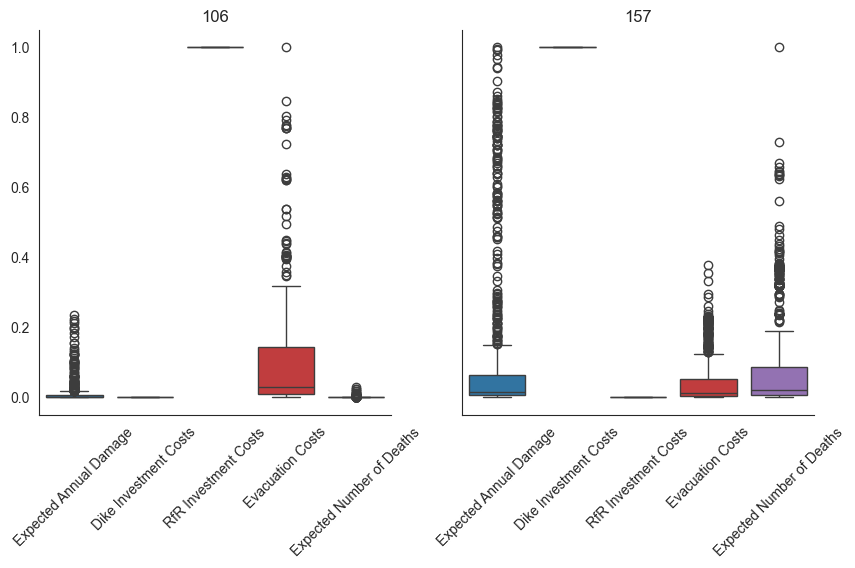

In [104]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [105]:
from ema_workbench.analysis import prim

x = experiments.drop(columns=['0_RfR 0',
                          '0_RfR 1',
                          '0_RfR 2',
                          '1_RfR 0',
                          '1_RfR 1',
                          '1_RfR 2',
                          '2_RfR 0',
                          '2_RfR 1',
                          '2_RfR 2',
                          '3_RfR 0',
                          '3_RfR 1',
                          '3_RfR 2',
                          '4_RfR 0',
                          '4_RfR 1',
                          '4_RfR 2',
                          'EWS_DaysToThreat',
                          'A.1_DikeIncrease 0',
                          'A.1_DikeIncrease 1',
                          'A.1_DikeIncrease 2',
                          'A.2_DikeIncrease 0',
                          'A.2_DikeIncrease 1',
                          'A.2_DikeIncrease 2',
                          'A.3_DikeIncrease 0',
                          'A.3_DikeIncrease 1',
                          'A.3_DikeIncrease 2',
                          'A.4_DikeIncrease 0',
                          'A.4_DikeIncrease 1',
                          'A.4_DikeIncrease 2',
                          'A.5_DikeIncrease 0',
                          'A.5_DikeIncrease 1',
                          'A.5_DikeIncrease 2',
                          'policy'
                          ])
# y = outcomes['RfR Investment Costs'] < 0.5

y = outcomes['Expected Number of Deaths'] < np.percentile(outcomes['Expected Number of Deaths'], 20)
prim_alg = prim.Prim(x, y, threshold=0.7)
box = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 6000 points remaining, containing 1200 cases of interest
[MainProcess/INFO] mean: 0.9738562091503268, mass: 0.051, coverage: 0.24833333333333332, density: 0.9738562091503268 restricted_dimensions: 5


In [106]:
box.inspect_tradeoff()

alt.VConcatChart(...)

In [122]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,119,41.172918,1.5,0.261706,147.253227,1.0,0.946389,304.567659,1.0,0.368598,...,0,3,0,2,1,0,0,1000,20,dikesnet
1,82,46.565828,1.5,0.015054,257.216589,1.0,0.238925,55.720023,1.0,0.841180,...,0,3,0,2,1,0,0,1001,20,dikesnet
2,83,38.144424,1.0,0.432869,243.937062,1.0,0.630017,331.615676,10.0,0.586234,...,0,3,0,2,1,0,0,1002,20,dikesnet
3,66,149.236257,10.0,0.843982,107.434345,10.0,0.400397,242.310127,10.0,0.496707,...,0,3,0,2,1,0,0,1003,20,dikesnet
4,2,286.741228,10.0,0.194898,185.773449,1.0,0.023117,285.275793,1.0,0.316449,...,0,3,0,2,1,0,0,1004,20,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,65,112.933991,1.0,0.426497,180.157424,1.0,0.837868,277.946196,1.5,0.810141,...,0,5,0,0,2,0,0,1995,196,dikesnet
5996,123,242.995318,1.5,0.105969,265.896076,1.5,0.233672,126.421841,1.0,0.389966,...,0,5,0,0,2,0,0,1996,196,dikesnet
5997,111,164.315870,1.5,0.388981,40.862808,1.0,0.549945,143.465440,1.5,0.527990,...,0,5,0,0,2,0,0,1997,196,dikesnet
5998,0,42.110318,10.0,0.346229,226.760367,1.0,0.423633,101.995765,1.0,0.469147,...,0,5,0,0,2,0,0,1998,196,dikesnet


In [123]:
outcomes.keys()

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])

In [205]:
all =experiments
keys = []
for key, outcome_array in outcomes.items():
    outcome_df = pd.DataFrame(outcome_array, columns=[key])
    all = pd.concat([all, outcome_df], axis=1)
    keys.append(key)
all

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,15,185.357856,10.0,0.309281,300.418134,1.5,0.740874,58.621498,1.0,0.197866,...,0,0,22000,170,dikesnet,4.580431e+07,7.885005e+07,503700000.0,0.000000,0.075583
1,102,127.883135,1.5,0.479149,116.692968,1.0,0.535493,239.537412,1.5,0.155555,...,0,0,22001,170,dikesnet,5.936864e+07,7.885005e+07,503700000.0,0.000000,0.097736
2,60,46.674204,10.0,0.552253,69.815564,1.5,0.520515,175.648703,1.5,0.919344,...,0,0,22002,170,dikesnet,5.301018e+07,7.885005e+07,503700000.0,0.000000,0.024578
3,103,281.077266,1.5,0.931733,80.187314,1.5,0.087467,116.200362,1.5,0.798733,...,0,0,22003,170,dikesnet,5.999341e+07,7.885005e+07,503700000.0,0.000000,0.057580
4,108,108.983415,1.5,0.199222,308.720104,1.0,0.457992,233.939327,1.5,0.961067,...,0,0,22004,170,dikesnet,3.346283e+07,7.885005e+07,503700000.0,0.000000,0.017160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,84,85.409014,10.0,0.143575,66.532872,10.0,0.670202,81.194233,1.5,0.877579,...,0,0,22995,208,dikesnet,1.556632e+09,7.630904e+07,540300000.0,20824.572138,0.132523
1996,56,152.533864,1.0,0.868004,62.432251,1.5,0.836366,323.392283,1.0,0.596676,...,0,0,22996,208,dikesnet,0.000000e+00,7.630904e+07,540300000.0,0.000000,0.000000
1997,8,138.914777,1.5,0.816917,256.439151,1.5,0.401750,106.768273,1.5,0.397486,...,0,0,22997,208,dikesnet,7.009704e+06,7.630904e+07,540300000.0,537.397380,0.001721
1998,41,302.798537,1.5,0.718543,103.522280,10.0,0.389305,39.044489,10.0,0.599666,...,0,0,22998,208,dikesnet,1.214519e+06,7.630904e+07,540300000.0,89.827186,0.000123


In [206]:
mean_df = all.groupby('policy')[keys].mean()
mean_df['all rfr + dike investment costs'] = mean_df['RfR Investment Costs'] + mean_df['Dike Investment Costs']
mean_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2511326581.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = all.groupby('policy')[keys].mean()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,all rfr + dike investment costs
policy,,,,,,
170,2.259444e+08,7.885005e+07,503700000.0,0.000000,0.217846,5.825501e+08
208,4.102174e+08,7.630904e+07,540300000.0,8467.847645,0.038042,6.166090e+08


In [207]:
min_df = all.groupby('policy')[keys].min()
min_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2689697923.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  min_df = all.groupby('policy')[keys].min()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
170,0.0,7.885005e+07,503700000.0,0.0,0.0
208,0.0,7.630904e+07,540300000.0,0.0,0.0


In [208]:
max_df = all.groupby('policy')[keys].max()
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\574521106.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
170,2.688396e+09,7.885005e+07,503700000.0,0.000000,2.567809
208,3.506067e+09,7.630904e+07,540300000.0,103454.091431,0.444762


In [204]:
n_scenarios = 10000
# new_policies_to_evaluate = []
# new_policies_to_evaluate.append(policies_to_evaluate[1])
# new_policies_to_evaluate.append(policies_to_evaluate[3])
# new_policies_to_evaluate.append(policies_to_evaluate[4])
# new_policies_to_evaluate.append(policies_to_evaluate[5])
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_8policies = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 10000 scenarios * 2 policies * 1 model(s) = 20000 experiments

100%|████████████████████████████████████| 20000/20000 [13:55<00:00, 23.93it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [150]:
new_policies_to_evaluate

[Policy({'0_RfR 0': 1.0, '0_RfR 1': 0.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 1.0, '3_RfR 0': 1.0, '3_RfR 1': 0.0, '3_RfR 2': 1.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 2.0, 'A.1_DikeIncrease 0': 0.0, 'A.1_DikeIncrease 1': 0.0, 'A.1_DikeIncrease 2': 0.0, 'A.2_DikeIncrease 0': 3.0, 'A.2_DikeIncrease 1': 0.0, 'A.2_DikeIncrease 2': 0.0, 'A.3_DikeIncrease 0': 0.0, 'A.3_DikeIncrease 1': 0.0, 'A.3_DikeIncrease 2': 0.0, 'A.4_DikeIncrease 0': 3.0, 'A.4_DikeIncrease 1': 0.0, 'A.4_DikeIncrease 2': 2.0, 'A.5_DikeIncrease 0': 2.0, 'A.5_DikeIncrease 1': 0.0, 'A.5_DikeIncrease 2': 0.0, 'Expected Annual Damage': 0.0, 'Dike Investment Costs': 91984024.21015486, 'RfR Investment Costs': 419100000.0, 'Evacuation Costs': 0.0, 'Expected Number of Deaths': 0.0}),
 Policy({'0_RfR 0': 1.0, '0_RfR 1': 0.0, '0_RfR 2': 1.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 

In [159]:
experiments, outcomes = results_8policies

all =experiments
keys = []
for key, outcome_array in outcomes.items():
    outcome_df = pd.DataFrame(outcome_array, columns=[key])
    all = pd.concat([all, outcome_df], axis=1)
    keys.append(key)
all

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,34,168.268144,10.0,0.920943,210.777920,1.5,0.947643,172.187199,1.0,0.111479,...,0,0,12000,78,dikesnet,9.701953e+07,9.198402e+07,419100000.0,3637.552099,0.022852
1,131,43.890479,1.0,0.427005,286.549220,1.0,0.991089,246.689613,10.0,0.789535,...,0,0,12001,78,dikesnet,2.870022e+07,9.198402e+07,419100000.0,872.158829,0.002650
2,86,59.517264,1.0,0.112557,334.367952,10.0,0.668562,328.650245,10.0,0.239958,...,0,0,12002,78,dikesnet,2.297361e+09,9.198402e+07,419100000.0,19955.257730,0.194334
3,56,192.587055,1.0,0.060317,324.081737,1.5,0.789080,303.172035,1.0,0.748427,...,0,0,12003,78,dikesnet,1.595471e+09,9.198402e+07,419100000.0,19312.606003,0.190937
4,108,105.825820,10.0,0.595038,110.784257,1.0,0.822366,135.869618,10.0,0.135725,...,0,0,12004,78,dikesnet,6.891471e+07,9.198402e+07,419100000.0,2356.438946,0.014752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,118,257.554398,1.0,0.792781,241.054316,10.0,0.449955,45.514043,1.5,0.527964,...,0,0,21995,196,dikesnet,1.507742e+07,1.086575e+08,388400000.0,1061.752971,0.001879
39996,125,43.369570,1.5,0.874815,208.234913,1.0,0.321441,48.043160,1.5,0.484851,...,0,0,21996,196,dikesnet,6.023366e+06,1.086575e+08,388400000.0,396.879472,0.000856
39997,46,172.544645,1.0,0.675452,109.060224,1.5,0.133685,310.584082,1.5,0.182132,...,0,0,21997,196,dikesnet,3.332332e+07,1.086575e+08,388400000.0,1693.895403,0.004444
39998,94,331.585961,1.5,0.347172,101.539358,1.0,0.555366,168.910971,1.5,0.632653,...,0,0,21998,196,dikesnet,1.602431e+07,1.086575e+08,388400000.0,178.050775,0.001256


In [160]:
mean_df = all.groupby('policy')[keys].mean()
mean_df['all rfr + dike investment costs'] = mean_df['RfR Investment Costs'] + mean_df['Dike Investment Costs']
mean_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2511326581.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = all.groupby('policy')[keys].mean()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,all rfr + dike investment costs
policy,,,,,,
157,1.890304e+08,8.827852e+07,881000000.0,4325.084573,0.025651,9.692785e+08
185,4.313998e+08,1.088155e+08,357700000.0,7616.041820,0.053358,4.665155e+08
196,3.993634e+08,1.086575e+08,388400000.0,7875.231373,0.036114,4.970575e+08
78,4.196172e+08,9.198402e+07,419100000.0,7237.942225,0.050421,5.110840e+08


In [161]:
max_df = all.groupby('policy')[keys].max()
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\574521106.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
157,3.577514e+09,8.827852e+07,881000000.0,98429.069976,0.556114
185,3.752750e+09,1.088155e+08,357700000.0,103147.319143,0.561881
196,3.641331e+09,1.086575e+08,388400000.0,103524.638908,0.446597
78,3.701836e+09,9.198402e+07,419100000.0,101843.186297,0.556783


<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2589759452.py:3: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel('$\epsilon$-progress')


NameError: name 'hypervolume' is not defined

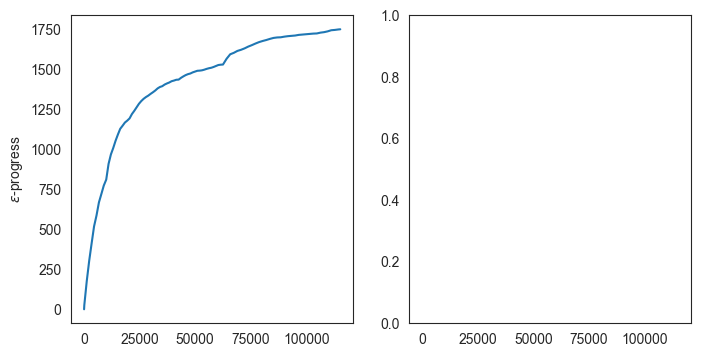

In [203]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [212]:
max_df = all.groupby('policy')[keys].max()
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\574521106.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
170,2.688396e+09,7.885005e+07,503700000.0,0.000000,2.567809
208,3.506067e+09,7.630904e+07,540300000.0,103454.091431,0.444762


In [213]:
idxmax_df = all.groupby('policy')[keys].idxmax()

# Create a DataFrame to store the maximum values and the corresponding scenarios
max_df = all.groupby('policy')[keys].max()
max_df['scenario'] = idxmax_df.apply(lambda x: all.loc[x, 'scenario'].values, axis=1)
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2832865992.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idxmax_df = all.groupby('policy')[keys].idxmax()
C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2832865992.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,scenario
policy,,,,,,
170,2.688396e+09,7.885005e+07,503700000.0,0.000000,2.567809,"[22293, 22000, 22000, 22000, 22643] Categories..."
208,3.506067e+09,7.630904e+07,540300000.0,103454.091431,0.444762,"[22078, 22000, 22000, 22078, 22078] Categories..."


In [221]:
all.iloc[1078][:19]

A.0_ID flood wave shape           113
A.1_Bmax                    80.278489
A.1_Brate                         1.5
A.1_pfail                    0.114615
A.2_Bmax                    170.40967
A.2_Brate                        10.0
A.2_pfail                    0.794863
A.3_Bmax                     254.3116
A.3_Brate                        10.0
A.3_pfail                      0.0004
A.4_Bmax                   290.262741
A.4_Brate                        10.0
A.4_pfail                    0.619422
A.5_Bmax                   263.797678
A.5_Brate                         1.5
A.5_pfail                    0.603587
discount rate 0                   3.5
discount rate 1                   1.5
discount rate 2                   3.5
Name: 1078, dtype: object

In [224]:
policy_dict = {
    'A.0_ID flood wave shape': 113,
    'A.1_Bmax': 80.278489,
    'A.1_Brate': 1.5,
    'A.1_pfail': 0.114615,
    'A.2_Bmax': 170.40967,
    'A.2_Brate': 10.0,
    'A.2_pfail': 0.794863,
    'A.3_Bmax': 254.3116,
    'A.3_Brate': 10.0,
    'A.3_pfail': 0.0004,
    'A.4_Bmax': 290.262741,
    'A.4_Brate': 10.0,
    'A.4_pfail': 0.619422,
    'A.5_Bmax': 263.797678,
    'A.5_Brate': 1.5,
    'A.5_pfail': 0.603587,
    'discount rate 0': 3.5,
    'discount rate 1': 1.5,
    'discount rate 2': 3.5
}

# Creating the policy using the Policy class
bad_scenario = Scenario('example_policy', **policy_dict)

In [223]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)

reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "discount rate 0": 3.5,
    "discount rate 1": 3.5,
    "discount rate 2": 3.5,
    "ID flood wave shape": 4,
}
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})
    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

nfe = 115000
new_levers = levers
convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimizer_sven_3.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

espilon = [1e3] * len(dike_model.outcomes)
espilon2 = [1018360, 919840, 4191000, 100180, 0.1]

In [225]:
bad_scenario

Scenario({'A.0_ID flood wave shape': 113, 'A.1_Bmax': 80.278489, 'A.1_Brate': 1.5, 'A.1_pfail': 0.114615, 'A.2_Bmax': 170.40967, 'A.2_Brate': 10.0, 'A.2_pfail': 0.794863, 'A.3_Bmax': 254.3116, 'A.3_Brate': 10.0, 'A.3_pfail': 0.0004, 'A.4_Bmax': 290.262741, 'A.4_Brate': 10.0, 'A.4_pfail': 0.619422, 'A.5_Bmax': 263.797678, 'A.5_Brate': 1.5, 'A.5_pfail': 0.603587, 'discount rate 0': 3.5, 'discount rate 1': 1.5, 'discount rate 2': 3.5})

In [226]:
ref_scenario

Scenario({'discount rate 0': 3.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5, 'A.0_ID flood wave shape': 4, 'A.1_Bmax': 175, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 'A.2_Bmax': 175, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5, 'A.3_Bmax': 175, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5, 'A.4_Bmax': 175, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5, 'A.5_Bmax': 175, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

In [227]:
nfe = 130000

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_optimization, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="levers",
        epsilons=espilon2,
        convergence=convergence_metrics,
        reference=bad_scenario,
        # constraints=constraints
    )

[MainProcess/INFO] pool started with 16 workers

100%|███████████████████████████████▉| 129983/130000 [1:35:18<00:00, 22.43it/s]
131431it [1:36:04, 22.80it/s]                                                  
[MainProcess/INFO] optimization completed, found 373 solutions
[MainProcess/INFO] terminating pool


In [230]:
save_results((results_optimization, convergence), 'data/runs/optimization_sven_3.tar.gz')

ValueError: too many values to unpack (expected 2)

In [308]:
import numpy as np

condition_deaths = results_optimization['Expected Number of Deaths'] < 0.02
condition_damage = results_optimization['Expected Annual Damage'] <  1.227898e+06
condition_RfRcosts = results_optimization['RfR Investment Costs'] > 176700000.0
condition_dikecosts = results_optimization['Dike Investment Costs'] < 3.043865e+08

logical = condition_deaths  & condition_damage & condition_RfRcosts &condition_dikecosts 

np.sum(logical)

8

In [246]:
policies = results_optimization[logical]
# policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)
# policies['total costs'] = policies['RfR Investment Costs'] + policies['Dike Investment Costs']
policies
from ema_workbench import Policy

policies_to_evaluate_3 = []

for i, policy in policies.iterrows():
    policies_to_evaluate_3.append(Policy(str(i), **policy.to_dict()))
policies_to_evaluate_3

[Policy({'0_RfR 0': 0.0, '0_RfR 1': 1.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 1.0, '3_RfR 0': 1.0, '3_RfR 1': 1.0, '3_RfR 2': 0.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 0.0, 'A.1_DikeIncrease 0': 3.0, 'A.1_DikeIncrease 1': 0.0, 'A.1_DikeIncrease 2': 0.0, 'A.2_DikeIncrease 0': 0.0, 'A.2_DikeIncrease 1': 0.0, 'A.2_DikeIncrease 2': 0.0, 'A.3_DikeIncrease 0': 10.0, 'A.3_DikeIncrease 1': 0.0, 'A.3_DikeIncrease 2': 0.0, 'A.4_DikeIncrease 0': 2.0, 'A.4_DikeIncrease 1': 0.0, 'A.4_DikeIncrease 2': 0.0, 'A.5_DikeIncrease 0': 1.0, 'A.5_DikeIncrease 1': 0.0, 'A.5_DikeIncrease 2': 0.0, 'Expected Annual Damage': 618554.5829809357, 'Dike Investment Costs': 118875820.32965362, 'RfR Investment Costs': 419100000.0, 'Evacuation Costs': 0.0, 'Expected Number of Deaths': 0.0005973376777374628}),
 Policy({'0_RfR 0': 0.0, '0_RfR 1': 0.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0'

In [247]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_policies_3 = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate_3)

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments

100%|██████████████████████████████████████| 8000/8000 [05:41<00:00, 23.41it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [248]:
experiments, outcomes = results_policies_3

all =experiments
keys = []
for key, outcome_array in outcomes.items():
    outcome_df = pd.DataFrame(outcome_array, columns=[key])
    all = pd.concat([all, outcome_df], axis=1)
    keys.append(key)
all

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,43,349.732971,10.0,0.998420,211.660508,1.0,0.616712,144.882486,1.0,0.223136,...,0,0,34000,44,dikesnet,1.547143e+08,1.188758e+08,419100000.0,0.0,0.154268
1,75,305.068703,1.0,0.466268,311.257538,1.0,0.963071,171.521177,1.0,0.425703,...,0,0,34001,44,dikesnet,6.741048e+07,1.188758e+08,419100000.0,0.0,0.048026
2,70,197.832289,10.0,0.695747,105.467089,1.0,0.715970,249.675180,10.0,0.471655,...,0,0,34002,44,dikesnet,1.326956e+07,1.188758e+08,419100000.0,0.0,0.011938
3,35,38.139356,1.5,0.417393,131.908210,10.0,0.329172,333.478780,1.0,0.083298,...,0,0,34003,44,dikesnet,3.248489e+07,1.188758e+08,419100000.0,0.0,0.032101
4,69,337.000824,1.5,0.842589,346.285457,10.0,0.549086,89.523880,1.5,0.604293,...,0,0,34004,44,dikesnet,1.944643e+07,1.188758e+08,419100000.0,0.0,0.017322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,36,132.706977,1.0,0.043295,318.914953,1.0,0.547599,293.992423,1.5,0.956796,...,0,0,34995,355,dikesnet,1.661655e+07,2.238074e+08,297900000.0,0.0,0.014991
7996,11,77.428673,1.5,0.269034,325.982288,10.0,0.111000,165.359348,1.5,0.335466,...,0,0,34996,355,dikesnet,9.406566e+07,2.238074e+08,297900000.0,0.0,0.093862
7997,44,85.889110,10.0,0.596717,150.417802,10.0,0.757694,109.176926,10.0,0.598904,...,0,0,34997,355,dikesnet,0.000000e+00,2.238074e+08,297900000.0,0.0,0.000000
7998,87,335.678653,10.0,0.390581,230.167840,1.5,0.033544,163.358122,10.0,0.055468,...,0,0,34998,355,dikesnet,4.426315e+08,2.238074e+08,297900000.0,0.0,0.404950


In [249]:
mean_df = all.groupby('policy')[keys].mean()
mean_df['all rfr + dike investment costs'] = mean_df['RfR Investment Costs'] + mean_df['Dike Investment Costs']
mean_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2511326581.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = all.groupby('policy')[keys].mean()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,all rfr + dike investment costs
policy,,,,,,
146,1.142031e+08,7.811405e+07,709500000.0,2665.164135,0.031949,7.876141e+08
162,1.099894e+08,2.280863e+08,213300000.0,0.000000,0.091289,4.413863e+08
245,1.733139e+08,1.092792e+08,503700000.0,6218.211193,0.020277,6.129792e+08
301,1.203274e+08,6.925223e+07,965600000.0,5969.694074,0.011202,1.034852e+09
321,1.202467e+08,8.301995e+07,588300000.0,2796.557685,0.034759,6.713200e+08
355,8.497229e+07,2.238074e+08,297900000.0,0.000000,0.066216,5.217074e+08
44,1.698114e+08,1.188758e+08,419100000.0,0.000000,0.132867,5.379758e+08
54,1.512295e+08,1.421963e+08,334500000.0,5845.928945,0.013966,4.766963e+08


In [250]:
max_df = all.groupby('policy')[keys].max()
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\574521106.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
146,2.340907e+09,7.811405e+07,709500000.0,25797.540009,0.473612
162,2.740712e+09,2.280863e+08,213300000.0,0.000000,1.611112
245,2.489332e+09,1.092792e+08,503700000.0,46116.742357,0.215859
301,2.360376e+09,6.925223e+07,965600000.0,53207.426269,0.160072
321,2.343825e+09,8.301995e+07,588300000.0,27778.555396,0.476363
355,2.344062e+09,2.238074e+08,297900000.0,0.000000,1.286081
44,2.489492e+09,1.188758e+08,419100000.0,0.000000,1.386717
54,2.866975e+09,1.421963e+08,334500000.0,57293.270504,0.217034


<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2589759452.py:3: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel('$\epsilon$-progress')


NameError: name 'hypervolume' is not defined

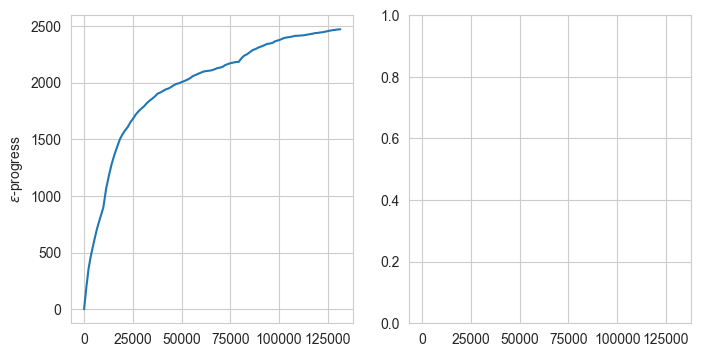

In [305]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [252]:
policies_to_evaluate_3

[Policy({'0_RfR 0': 0.0, '0_RfR 1': 1.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 1.0, '3_RfR 0': 1.0, '3_RfR 1': 1.0, '3_RfR 2': 0.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 0.0, 'A.1_DikeIncrease 0': 3.0, 'A.1_DikeIncrease 1': 0.0, 'A.1_DikeIncrease 2': 0.0, 'A.2_DikeIncrease 0': 0.0, 'A.2_DikeIncrease 1': 0.0, 'A.2_DikeIncrease 2': 0.0, 'A.3_DikeIncrease 0': 10.0, 'A.3_DikeIncrease 1': 0.0, 'A.3_DikeIncrease 2': 0.0, 'A.4_DikeIncrease 0': 2.0, 'A.4_DikeIncrease 1': 0.0, 'A.4_DikeIncrease 2': 0.0, 'A.5_DikeIncrease 0': 1.0, 'A.5_DikeIncrease 1': 0.0, 'A.5_DikeIncrease 2': 0.0, 'Expected Annual Damage': 618554.5829809357, 'Dike Investment Costs': 118875820.32965362, 'RfR Investment Costs': 419100000.0, 'Evacuation Costs': 0.0, 'Expected Number of Deaths': 0.0005973376777374628}),
 Policy({'0_RfR 0': 0.0, '0_RfR 1': 0.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0'

In [259]:
policies_to_evaluate_4 = []
policies_to_evaluate_4.append(policies_to_evaluate_3[1])
policies_to_evaluate_4.append(policies_to_evaluate_3[4])
policies_to_evaluate_4.append(policies_to_evaluate_3[5])

In [260]:
policies_to_evaluate_4

[Policy({'0_RfR 0': 0.0, '0_RfR 1': 0.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 1.0, '3_RfR 0': 1.0, '3_RfR 1': 1.0, '3_RfR 2': 0.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 3.0, 'A.1_DikeIncrease 0': 5.0, 'A.1_DikeIncrease 1': 0.0, 'A.1_DikeIncrease 2': 0.0, 'A.2_DikeIncrease 0': 0.0, 'A.2_DikeIncrease 1': 0.0, 'A.2_DikeIncrease 2': 0.0, 'A.3_DikeIncrease 0': 10.0, 'A.3_DikeIncrease 1': 0.0, 'A.3_DikeIncrease 2': 0.0, 'A.4_DikeIncrease 0': 2.0, 'A.4_DikeIncrease 1': 0.0, 'A.4_DikeIncrease 2': 0.0, 'A.5_DikeIncrease 0': 5.0, 'A.5_DikeIncrease 1': 0.0, 'A.5_DikeIncrease 2': 0.0, 'Expected Annual Damage': 618554.5829809357, 'Dike Investment Costs': 142196282.6163557, 'RfR Investment Costs': 334500000.0, 'Evacuation Costs': 33.845757127919164, 'Expected Number of Deaths': 7.168052132849553e-05}),
 Policy({'0_RfR 0': 1.0, '0_RfR 1': 0.0, '0_RfR 2': 1.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 

In [261]:
n_scenarios = 10000
with MultiprocessingEvaluator(dike_model, n_processes=-2) as evaluator:
    results_policies_4 = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate_4)

[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 10000 scenarios * 3 policies * 1 model(s) = 30000 experiments

100%|████████████████████████████████████| 30000/30000 [23:14<00:00, 21.51it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [334]:
experiments, outcomes = results_policies_4

all =experiments
keys = []
for key, outcome_array in outcomes.items():
    outcome_df = pd.DataFrame(outcome_array, columns=[key])
    all = pd.concat([all, outcome_df], axis=1)
    keys.append(key)
all

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,39,191.983480,1.5,0.912464,99.469592,1.0,0.776715,154.865143,1.5,0.635678,...,0,0,35000,54,dikesnet,3.353827e+06,1.421963e+08,334500000.0,156.368064,0.000332
1,35,113.718822,1.5,0.564079,251.011673,1.5,0.680487,98.735310,10.0,0.684109,...,0,0,35001,54,dikesnet,1.226597e+07,1.421963e+08,334500000.0,627.695118,0.001324
2,106,33.645493,1.0,0.355201,128.706362,10.0,0.304991,304.913197,1.0,0.825079,...,0,0,35002,54,dikesnet,6.019297e+07,1.421963e+08,334500000.0,3187.135435,0.005376
3,71,162.930925,10.0,0.229258,204.435694,1.5,0.656631,344.501711,10.0,0.665681,...,0,0,35003,54,dikesnet,6.462883e+06,1.421963e+08,334500000.0,392.662652,0.000831
4,75,69.024816,1.5,0.066405,256.294613,1.0,0.447511,49.108133,10.0,0.109870,...,0,0,35004,54,dikesnet,6.271209e+07,1.421963e+08,334500000.0,1658.255086,0.005523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,129,99.174818,10.0,0.638218,330.511775,1.5,0.646689,169.792865,1.0,0.650642,...,0,0,44995,301,dikesnet,2.922854e+07,6.925223e+07,965600000.0,2310.779692,0.001701
29996,92,115.940585,1.0,0.527883,124.761296,1.5,0.846025,299.346262,10.0,0.938914,...,0,0,44996,301,dikesnet,3.323151e+07,6.925223e+07,965600000.0,2306.382703,0.001529
29997,116,301.980463,10.0,0.124344,224.297156,1.5,0.535660,324.877072,1.5,0.367733,...,0,0,44997,301,dikesnet,8.163148e+06,6.925223e+07,965600000.0,618.389184,0.001269
29998,90,80.551567,1.0,0.884608,36.623963,10.0,0.301062,347.788350,10.0,0.851137,...,0,0,44998,301,dikesnet,3.883274e+07,6.925223e+07,965600000.0,2627.779152,0.004198


In [266]:
mean_df = all.groupby('policy')[keys].mean()
mean_df['all rfr + dike investment costs'] = mean_df['RfR Investment Costs'] + mean_df['Dike Investment Costs']
mean_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2511326581.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = all.groupby('policy')[keys].mean()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,all rfr + dike investment costs
policy,,,,,,
245,1.704011e+08,1.092792e+08,503700000.0,6096.024351,0.020045,6.129792e+08
301,1.167947e+08,6.925223e+07,965600000.0,5824.746443,0.011027,1.034852e+09
54,1.479356e+08,1.421963e+08,334500000.0,5738.612371,0.013812,4.766963e+08


In [338]:
max_df = all.groupby('policy')[keys].max()
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\574521106.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
245,2.864573e+09,1.092792e+08,503700000.0,63512.404935,0.274526
301,2.950784e+09,6.925223e+07,965600000.0,62532.181115,0.205501
54,3.174151e+09,1.421963e+08,334500000.0,67560.901928,0.255531


In [276]:
all[all['policy'] == '301']

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
20000,39,191.983480,1.5,0.912464,99.469592,1.0,0.776715,154.865143,1.5,0.635678,...,0,0,35000,301,dikesnet,2.347437e+06,6.925223e+07,965600000.0,109.541653,0.000232
20001,35,113.718822,1.5,0.564079,251.011673,1.5,0.680487,98.735310,10.0,0.684109,...,0,0,35001,301,dikesnet,7.678927e+06,6.925223e+07,965600000.0,392.615290,0.000831
20002,106,33.645493,1.0,0.355201,128.706362,10.0,0.304991,304.913197,1.0,0.825079,...,0,0,35002,301,dikesnet,7.104551e+07,6.925223e+07,965600000.0,4171.261295,0.005296
20003,71,162.930925,10.0,0.229258,204.435694,1.5,0.656631,344.501711,10.0,0.665681,...,0,0,35003,301,dikesnet,9.615857e+06,6.925223e+07,965600000.0,649.536342,0.001032
20004,75,69.024816,1.5,0.066405,256.294613,1.0,0.447511,49.108133,10.0,0.109870,...,0,0,35004,301,dikesnet,1.488984e+07,6.925223e+07,965600000.0,768.067293,0.001565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,129,99.174818,10.0,0.638218,330.511775,1.5,0.646689,169.792865,1.0,0.650642,...,0,0,44995,301,dikesnet,2.922854e+07,6.925223e+07,965600000.0,2310.779692,0.001701
29996,92,115.940585,1.0,0.527883,124.761296,1.5,0.846025,299.346262,10.0,0.938914,...,0,0,44996,301,dikesnet,3.323151e+07,6.925223e+07,965600000.0,2306.382703,0.001529
29997,116,301.980463,10.0,0.124344,224.297156,1.5,0.535660,324.877072,1.5,0.367733,...,0,0,44997,301,dikesnet,8.163148e+06,6.925223e+07,965600000.0,618.389184,0.001269
29998,90,80.551567,1.0,0.884608,36.623963,10.0,0.301062,347.788350,10.0,0.851137,...,0,0,44998,301,dikesnet,3.883274e+07,6.925223e+07,965600000.0,2627.779152,0.004198


In [282]:
all.iloc[23666,19:50]

0_RfR 0                1
0_RfR 1                1
0_RfR 2                1
1_RfR 0                0
1_RfR 1                0
1_RfR 2                0
2_RfR 0                1
2_RfR 1                1
2_RfR 2                1
3_RfR 0                1
3_RfR 1                1
3_RfR 2                1
4_RfR 0                1
4_RfR 1                0
4_RfR 2                0
EWS_DaysToThreat       3
A.1_DikeIncrease 0     0
A.1_DikeIncrease 1     0
A.1_DikeIncrease 2     0
A.2_DikeIncrease 0     0
A.2_DikeIncrease 1     0
A.2_DikeIncrease 2     0
A.3_DikeIncrease 0    10
A.3_DikeIncrease 1     0
A.3_DikeIncrease 2     0
A.4_DikeIncrease 0     0
A.4_DikeIncrease 1     0
A.4_DikeIncrease 2     0
A.5_DikeIncrease 0     1
A.5_DikeIncrease 1     0
A.5_DikeIncrease 2     0
Name: 23666, dtype: object

In [293]:
# Creating the policy dictionary based on the image data
policy_dict = {
    '0_RfR 0': 1,
    '0_RfR 1': 1,
    '0_RfR 2': 1,
    '1_RfR 0': 0,
    '1_RfR 1': 0,
    '1_RfR 2': 0,
    '2_RfR 0': 1,
    '2_RfR 1': 1,
    '2_RfR 2': 1,
    '3_RfR 0': 1,
    '3_RfR 1': 1,
    '3_RfR 2': 1,
    '4_RfR 0': 1,
    '4_RfR 1': 0,
    '4_RfR 2': 0,
    'EWS_DaysToThreat': 3,
    'A.1_DikeIncrease 0': 0,
    'A.1_DikeIncrease 1': 0,
    'A.1_DikeIncrease 2': 0,
    'A.2_DikeIncrease 0': 0,
    'A.2_DikeIncrease 1': 0,
    'A.2_DikeIncrease 2': 0,
    'A.3_DikeIncrease 0': 10,
    'A.3_DikeIncrease 1': 0,
    'A.3_DikeIncrease 2': 0,
    'A.4_DikeIncrease 0': 1,
    'A.4_DikeIncrease 1': 0,
    'A.4_DikeIncrease 2': 0,
    'A.5_DikeIncrease 0': 0,
    'A.5_DikeIncrease 1': 0,
    'A.5_DikeIncrease 2': 0,
}

# Creating the policy using the Policy class
policy = Policy('example_policy', **policy_dict)

# Display the policy
print(policy)

Policy({'0_RfR 0': 1, '0_RfR 1': 1, '0_RfR 2': 1, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 1, '2_RfR 2': 1, '3_RfR 0': 1, '3_RfR 1': 1, '3_RfR 2': 1, '4_RfR 0': 1, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 10, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 3, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 3, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0})


In [294]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model, n_processes=-2) as evaluator:
    test = evaluator.perform_experiments(n_scenarios,
                                            policy)

[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments

100%|██████████████████████████████████████| 1000/1000 [00:42<00:00, 23.37it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [295]:
experiments, outcomes = test

all =experiments
keys = []
for key, outcome_array in outcomes.items():
    outcome_df = pd.DataFrame(outcome_array, columns=[key])
    all = pd.concat([all, outcome_df], axis=1)
    keys.append(key)
all

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,122,155.676350,1.5,0.847184,267.084467,1.0,0.887953,287.297750,1.0,0.427728,...,0,0,47000,example_policy,dikesnet,0.000000e+00,8.301995e+07,965600000.0,0.000000,0.000000
1,125,84.823911,1.5,0.212295,89.445060,1.0,0.975790,349.232634,10.0,0.079197,...,0,0,47001,example_policy,dikesnet,0.000000e+00,8.301995e+07,965600000.0,0.000000,0.000000
2,4,153.128391,1.5,0.826518,123.259069,10.0,0.756397,85.295248,1.0,0.581491,...,0,0,47002,example_policy,dikesnet,2.149668e+06,8.301995e+07,965600000.0,138.119443,0.000254
3,5,309.426502,10.0,0.240914,91.592618,1.0,0.501496,205.955462,1.5,0.968425,...,0,0,47003,example_policy,dikesnet,1.254331e+07,8.301995e+07,965600000.0,770.725192,0.001580
4,76,165.101193,10.0,0.698091,73.825874,1.5,0.509339,52.109067,1.5,0.611423,...,0,0,47004,example_policy,dikesnet,1.708544e+07,8.301995e+07,965600000.0,990.647136,0.002036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,65,230.324525,1.0,0.862160,192.944892,1.0,0.914603,94.408506,1.5,0.351648,...,0,0,47995,example_policy,dikesnet,0.000000e+00,8.301995e+07,965600000.0,0.000000,0.000000
996,124,47.044136,10.0,0.149548,215.957804,1.5,0.475456,155.826447,1.5,0.109991,...,0,0,47996,example_policy,dikesnet,1.305880e+07,8.301995e+07,965600000.0,989.483898,0.002029
997,0,185.531443,10.0,0.986810,92.066635,1.5,0.454561,311.819295,10.0,0.081455,...,0,0,47997,example_policy,dikesnet,1.831260e+07,8.301995e+07,965600000.0,989.219922,0.002027
998,0,310.014090,10.0,0.392678,219.008935,1.0,0.535434,117.880626,1.0,0.295963,...,0,0,47998,example_policy,dikesnet,1.404375e+07,8.301995e+07,965600000.0,773.201163,0.001595


In [296]:
mean_df = all.groupby('policy')[keys].mean()
mean_df['all rfr + dike investment costs'] = mean_df['RfR Investment Costs'] + mean_df['Dike Investment Costs']
mean_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\2511326581.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = all.groupby('policy')[keys].mean()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,all rfr + dike investment costs
policy,,,,,,
example_policy,1.021939e+08,8.301995e+07,965600000.0,4698.858108,0.0099,1.048620e+09


In [297]:
max_df = all.groupby('policy')[keys].max()
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\574521106.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
example_policy,3.027531e+09,8.301995e+07,965600000.0,65668.7326,0.219931


In [ ]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('max_P') 
plt.show()

In [324]:
data = results_optimization.iloc[[245, 301, 54]]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
245,1,0,1,0,0,0,1,1,1,1,...,0,0,1,0,0,618554.582981,1.092792e+08,503700000.0,27.243270,0.000090
301,1,1,1,0,0,0,1,1,1,1,...,0,0,1,0,0,937106.207109,6.925223e+07,965600000.0,66.220233,0.000058
54,0,0,0,0,0,0,1,1,1,1,...,0,0,5,0,0,618554.582981,1.421963e+08,334500000.0,33.845757,0.000072


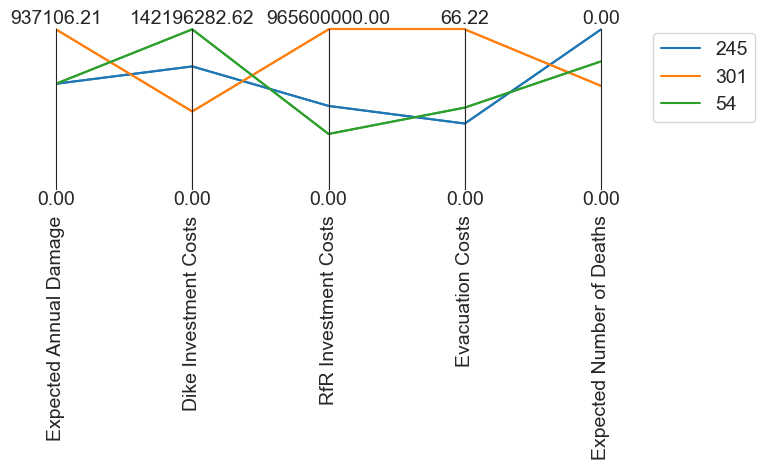

In [329]:
data = data.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

In [336]:
mean_df = all.groupby('policy')[keys].mean()
# mean_df['all rfr + dike investment costs'] = mean_df['RfR Investment Costs'] + mean_df['Dike Investment Costs']
mean_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\308776762.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = all.groupby('policy')[keys].mean()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
245,1.704011e+08,1.092792e+08,503700000.0,6096.024351,0.020045
301,1.167947e+08,6.925223e+07,965600000.0,5824.746443,0.011027
54,1.479356e+08,1.421963e+08,334500000.0,5738.612371,0.013812


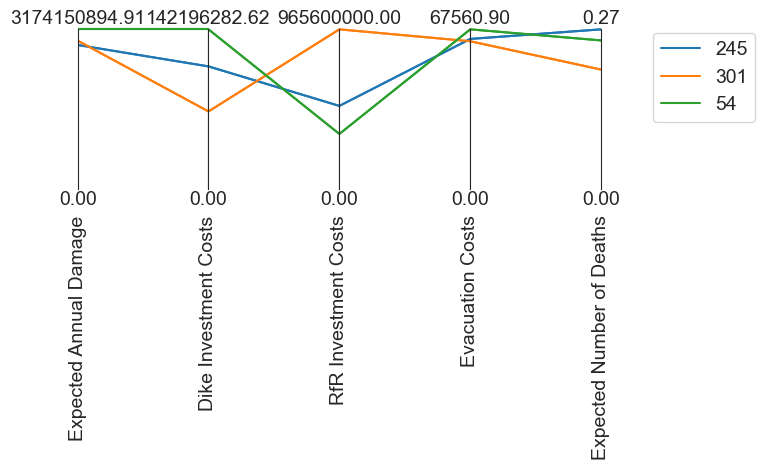

In [339]:
limits = parcoords.get_limits(max_df)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(max_df)
for i, (index, row) in enumerate(max_df.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

In [342]:
convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimizer_sven_50k.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]
with MultiprocessingEvaluator(dike_model, n_processes=-1) as evaluator:
    results_optimization, convergence = evaluator.optimize(
        nfe=50000,
        searchover="levers",
        epsilons=espilon,
        convergence=convergence_metrics,
        reference=ref_scenario,
        # constraints=constraints
    )

[MainProcess/INFO] pool started with 15 workers


  0%|                                                | 0/50000 [00:00<?, ?it/s]

  0%|                                      | 100/50000 [00:03<33:09, 25.08it/s]

  0%|▏                                     | 200/50000 [00:08<33:40, 24.65it/s]

  1%|▏                                     | 300/50000 [00:12<33:40, 24.60it/s]

  1%|▎                                     | 400/50000 [00:16<33:45, 24.49it/s]

  1%|▍                                     | 500/50000 [00:20<33:49, 24.39it/s]

  1%|▍                                     | 599/50000 [00:24<33:55, 24.27it/s]

  1%|▌                                     | 698/50000 [00:28<34:14, 24.00it/s]

  2%|▌                                     | 798/50000 [00:32<34:15, 23.94it/s]

  2%|▋                                     | 898/50000 [00:37<34:13, 23.91it/s]

  2%|▊                                     | 998/50000 [00:41<34:14, 23.85it/s]

  2%|▊                                    | 1098/50000 [00:

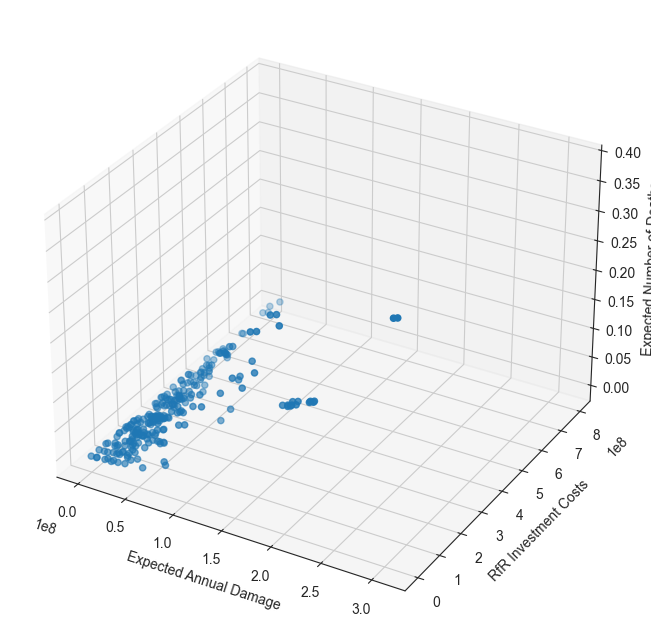

In [343]:
from mpl_toolkits.mplot3d import Axes3D  

outcomes = results_optimization.loc[:, ['Expected Annual Damage', 'RfR Investment Costs', 'Expected Number of Deaths']]

fig = plt.figure(figsize=(8,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outcomes['Expected Annual Damage'], outcomes['RfR Investment Costs'], outcomes['Expected Number of Deaths'])
ax.set_xlabel('Expected Annual Damage')
ax.set_ylabel('RfR Investment Costs')
ax.set_zlabel('Expected Number of Deaths')
plt.show()

In [344]:
import numpy as np

condition_deaths = results_optimization['Expected Number of Deaths'] < 0.3
condition_damage = results_optimization['Expected Annual Damage'] <  1.227898e+05
condition_RfRcosts = results_optimization['RfR Investment Costs'] > 176700000.0
condition_dikecosts = results_optimization['Dike Investment Costs'] < 3.043865e+08

logical = condition_deaths  & condition_damage & condition_RfRcosts &condition_dikecosts 

np.sum(logical)

5

In [345]:
policies = results_optimization[logical]
# policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)
# policies['total costs'] = policies['RfR Investment Costs'] + policies['Dike Investment Costs']
policies
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
policies_to_evaluate

[Policy({'0_RfR 0': 0.0, '0_RfR 1': 1.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 1.0, '3_RfR 0': 1.0, '3_RfR 1': 0.0, '3_RfR 2': 1.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 2.0, 'A.1_DikeIncrease 0': 0.0, 'A.1_DikeIncrease 1': 0.0, 'A.1_DikeIncrease 2': 0.0, 'A.2_DikeIncrease 0': 3.0, 'A.2_DikeIncrease 1': 0.0, 'A.2_DikeIncrease 2': 0.0, 'A.3_DikeIncrease 0': 0.0, 'A.3_DikeIncrease 1': 0.0, 'A.3_DikeIncrease 2': 0.0, 'A.4_DikeIncrease 0': 4.0, 'A.4_DikeIncrease 1': 0.0, 'A.4_DikeIncrease 2': 0.0, 'A.5_DikeIncrease 0': 3.0, 'A.5_DikeIncrease 1': 0.0, 'A.5_DikeIncrease 2': 0.0, 'Expected Annual Damage': 0.0, 'Dike Investment Costs': 87889420.96764514, 'RfR Investment Costs': 419100000.0, 'Evacuation Costs': 0.0, 'Expected Number of Deaths': 0.0}),
 Policy({'0_RfR 0': 0.0, '0_RfR 1': 1.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 0.0, '2_RfR 2': 

In [347]:
n_scenarios = 1000
# new_policies_to_evaluate = []
# new_policies_to_evaluate.append(policies_to_evaluate[1])
# new_policies_to_evaluate.append(policies_to_evaluate[3])
# new_policies_to_evaluate.append(policies_to_evaluate[4])
# new_policies_to_evaluate.append(policies_to_evaluate[5])
with MultiprocessingEvaluator(dike_model, n_processes=-2) as evaluator:
    results_policies_50k = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 14 workers

100%|██████████████████████████████████████| 5000/5000 [03:45<00:00, 22.13it/s]
[MainProcess/INFO] terminating pool


In [350]:
experiments, outcomes = results_policies_50k

all =experiments
keys = []
for key, outcome_array in outcomes.items():
    outcome_df = pd.DataFrame(outcome_array, columns=[key])
    all = pd.concat([all, outcome_df], axis=1)
    keys.append(key)
all

mean_df = all.groupby('policy')[keys].mean()
# mean_df['all rfr + dike investment costs'] = mean_df['RfR Investment Costs'] + mean_df['Dike Investment Costs']
mean_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\467254540.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = all.groupby('policy')[keys].mean()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
101,4.058268e+08,8.788942e+07,419100000.0,6777.358768,0.049692
108,4.159068e+08,1.069469e+08,388400000.0,8969.103688,0.041270
111,3.927072e+08,1.157808e+08,297900000.0,6197.147659,0.046075
237,2.040796e+08,1.118410e+08,351800000.0,3089.448776,0.068377
252,2.042445e+08,8.664763e+07,503700000.0,3078.764677,0.072600


In [351]:
max_df = all.groupby('policy')[keys].max()
max_df

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\574521106.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_df = all.groupby('policy')[keys].max()


,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
101,4.723729e+09,8.788942e+07,419100000.0,83289.621028,0.556707
108,4.727546e+09,1.069469e+08,388400000.0,103509.581022,0.446239
111,4.725006e+09,1.157808e+08,297900000.0,83298.912746,0.557072
237,4.727027e+09,1.118410e+08,351800000.0,50201.842261,1.340598
252,4.719826e+09,8.664763e+07,503700000.0,50170.552151,1.335631


In [352]:
data = mean_df

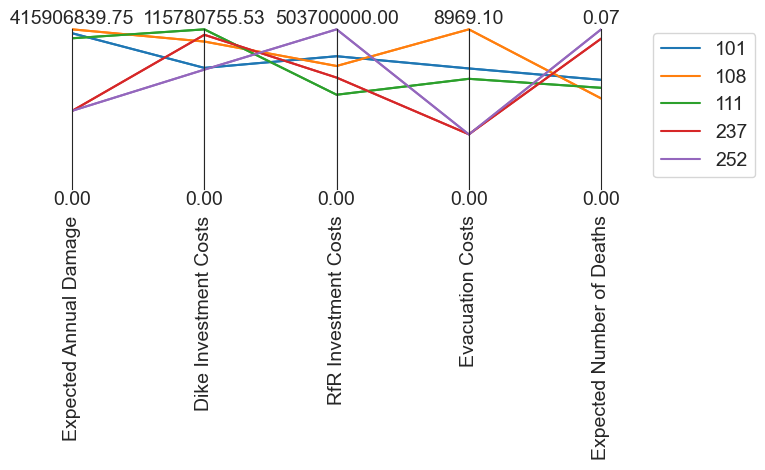

In [353]:
data = data.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

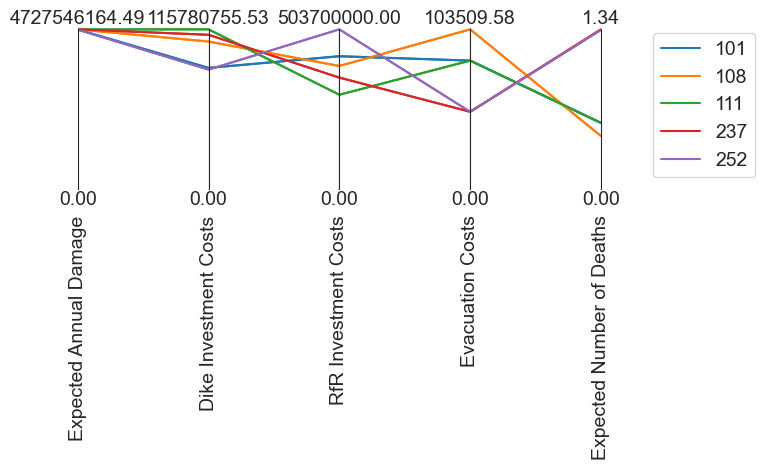

In [354]:
data = max_df.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()